In [1]:
#clone git repo
!git clone https://github.com/NBar05/MOSD_project_2022

# go to TS-CP model
%cd MOSD_project_2022/tscp/

Cloning into 'MOSD_project_2022'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 176 (delta 40), reused 0 (delta 0), pack-reused 104
Receiving objects: 100% (176/176), 26.68 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/MOSD_project_2022/tscp


In [2]:
# SOME INSTALLATIONS
!pip install ruptures
!pip install -q pytorch-lightning
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 24.3 MB/s 
     |████████████████████████████████| 800 kB 17.8 MB/s 
     |████████████████████████████████| 512 kB 34.2 MB/s 
     |████████████████████████████████| 125 kB 47.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# LIBRARIES

import torch
import torchtext
from torchvision import transforms
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from torch.utils import data

import pytorch_lightning as pl
import matplotlib.pyplot as plt

from math import floor
from pandas import read_csv
from sklearn.metrics import roc_auc_score
import pandas as pd
import csv
import os
import scipy.io as sio

from IPython.display import clear_output
import numpy as np
from ruptures.metrics import precision_recall

def fuzzy_f1_score(y_true: np.array, y_pred: np.array, margin: int=10):    
    bkps1 = np.arange(0, len(y_true))[y_true == 1]
    bkps2 = np.arange(0, len(y_pred))[y_pred == 1]

    bkps1 = np.array(list(bkps1) + [len(y_true)-1]) if bkps1[-1] != len(y_true)-1 else bkps1
    bkps2 = np.array(list(bkps2) + [len(y_true)-1]) if bkps2[-1] != len(y_true)-1 else bkps2
    
    p, r = precision_recall(bkps1, bkps2, margin=margin)

    return 2 * (p * r) / (p + r)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# for reproducibility issues
def reproducibility(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    
reproducibility(42)

# import all necessay functions
from tscp_new import *

import warnings
warnings.filterwarnings("ignore")

cuda:0


# USC part

## Illustration USC dataset

In [4]:
path= "data/"
dataset = sio.loadmat(path+"usc.mat")
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Oct 19 14:01:57 2020',
 '__version__': '1.0',
 '__globals__': [],
 'L': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'Y': array([[0.179207  ],
        [0.16998498],
        [0.16555306],
        ...,
        [0.33397986],
        [0.33366157],
        [0.3323591 ]])}

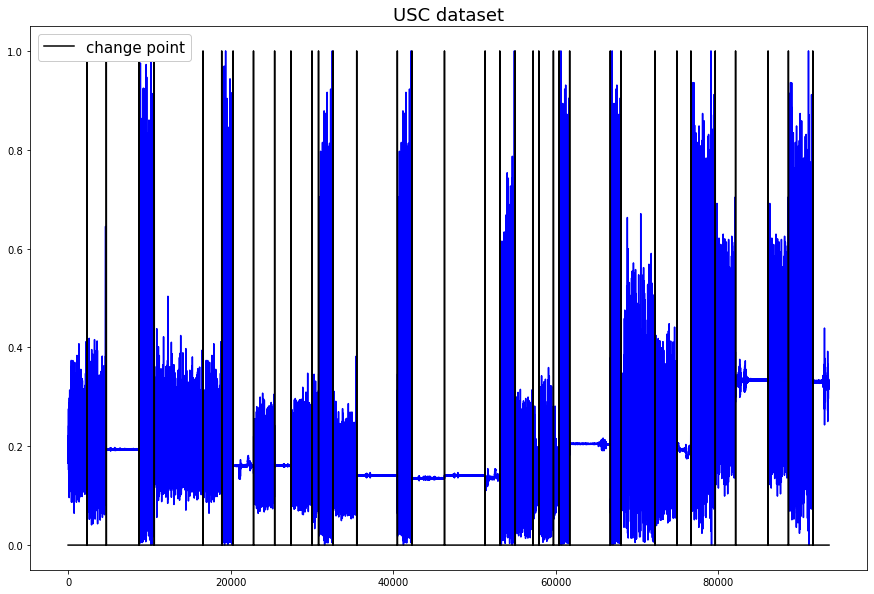

In [5]:
plt.figure(figsize = (15, 10))
plt.title("USC dataset", fontsize = 18)
plt.plot(dataset["Y"][:,0], color = "blue");
plt.plot(dataset["L"], color = "black", label = "change point");
plt.legend(framealpha=1, fontsize = 15);




# USC preprocess

In [6]:
##### USC

def extract_windows(path, window_size, step):

    print(window_size)
    windows = []
    lbl = []
    dataset = sio.loadmat(path+"usc.mat")

    ts = np.array(dataset['Y'])
    ts = ts[:,0]
    cp = np.array(dataset['L'])
    cp = cp[:,0]

    num_cp = 0
    #ts = np.sqrt(np.power(x[:, 0], 2) + np.power(x[:, 1], 2) + np.power(x[:, 2], 2))
    for i in range(0, ts.shape[0] - window_size, step):
        windows.append(np.array(ts[i:i + window_size]))
        is_cp = np.where(cp[i:i + window_size] == 1)[0]
        if is_cp.size == 0:
            is_cp = [0]
        else:
            num_cp += 1
        lbl.append(is_cp[0])

    print("number of samples : {} /  number of samples with change point : {}".format(len(windows), num_cp))
    windows = np.array(windows)

    return windows, np.array(lbl)

def load_usc_ds(path, window, train_share = 0.8, step = 5, mode='train'):

    X, lbl = extract_windows(path, window, step)

    if mode == "all":
        return X, lbl
    train_size = int(floor(train_share * X.shape[0]))
    if mode == "train":
        trainx = X[0:train_size]
        trainlbl = lbl[0:train_size]
        idx = np.arange(trainx.shape[0])
        np.random.shuffle(idx)
        trainx = trainx[idx,]
        trainlbl = trainlbl[idx]
        print('train samples : ', train_size)
        return trainx, trainlbl

    else:
        testx = X[train_size:]
        testlbl = lbl[train_size:]
        print('test shape {} and number of change points {} '.format(testx.shape, len(np.where(testlbl > 0)[0])))

        return testx, testlbl


class Prepare_dataset(torch.utils.data.Dataset):    
    
    def __init__(self, path, labels):
        
        self.path = path
        self.labels = labels
    
    def __len__(self):
        
        return len(self.path)
    
    def __getitem__(self, index):
        series = self.path[index]
        tensor_of_image = torch.tensor(series)
        label = self.labels[index]
        
        return tensor_of_image, label 
        #return np.concatenate((label, tensor_of_image), 1)

def load_dataset(path, ds_name, win, bs, mode="train"):
    if ds_name == 'HASC':
        data, label = load_hasc_ds(path, window = 2 * win, train_share = 0.8, step = 5, mode='train')
    elif ds_name == "USC":
        data, label = load_usc_ds(path, window = 2 * win, mode=mode)
    else:
        raise ValueError("Undefined Dataset.")

    label = label.reshape((label.shape[0], 1))
    print(data.shape, label.shape)
    
    #dataset = np.concatenate((trainlbl, trainx), 1)

    #print("dataset shape : ", dataset.shape)
    if mode == "train":
        data_train = Prepare_dataset(data, label)
        dataloader_train = torch.utils.data.DataLoader(data_train,
                                                       batch_size=bs,
                                                       shuffle=True)
        return dataloader_train
        
    
    
    if mode == "test":
        data_test = Prepare_dataset(data, label)
        dataloader_test = torch.utils.data.DataLoader(data_test,
                                                      batch_size=bs,
                                                      shuffle=False)

        return dataloader_test

### Parameters

In [7]:
window = 400
code_size = 10
seq_len = window
margin = 1
quantile = 0.05
train_share = 0.8
# as in the article
bs = 32
step = 20
epochs = 5
# folowing the article dilations:
dilations = [1, 4, 16]
nb_stacks = 2
kernel_size = 4
nb_filters = 64
temperature = 0.1
dataset_name = "USC"

In [8]:
path= "data/"
dataset = sio.loadmat(path+"usc.mat")
windows, labels = extract_windows(path = path, window_size=window, step = step)

400
number of samples : 4662 /  number of samples with change point : 700


In [9]:
trainx, trainlbl = load_usc_ds(path = "data/", window = window*2, train_share = train_share, step = step, mode='train')
testx, testlbl = load_usc_ds(path = "data/", window = window*2, train_share = train_share, step = step, mode='test')

800
number of samples : 4642 /  number of samples with change point : 1390
train samples :  3713
800
number of samples : 4642 /  number of samples with change point : 1390
test shape (929, 800) and number of change points 273 


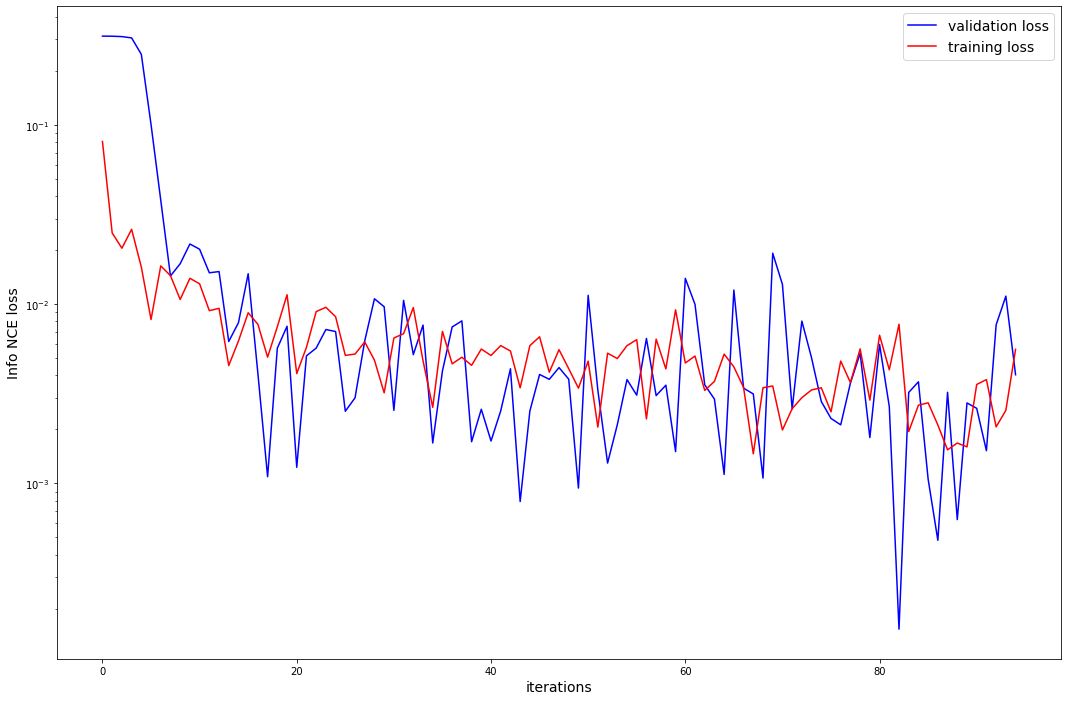

100%|██████████| 5/5 [01:02<00:00, 12.57s/it]


In [10]:
encoder = Encoder(c_in = 1, nb_filters=nb_filters, kernel_size=kernel_size, dilations = dilations, 
                  nb_stacks=nb_stacks, n_steps=50, code_size=code_size, seq_len=seq_len)

model = TSCP_model(
    model=encoder,
    train_dataset=trainx,
    test_dataset=testx,
    batch_size=bs,
    num_workers=4,
    temperature = temperature,
    lr= 0.0001,
    decay_steps= 1000,
    window_1 = window,
    window_2 = window
)

model = model.to(device)

optimizer = model.configure_optimizers()

train_loader = model.train_dataloader()
val_loader = model.val_dataloader()

train_losses = []
val_losses = []

total_iterations = 0
for epoch in tqdm(range(epochs)):
    
    iteration = 0
    train_losses_4_iters = []
    
    for index, batch in enumerate(train_loader):
        
        batch = batch.to(device)
        index = torch.tensor(index).to(device)
        
        if iteration != 5:
            
            loss = model.training_step(batch, index)
            train_losses_4_iters.append(float(loss))
            #print("train_losses_4_iters", train_losses_4_iters)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iteration += 1
            
            #print("iteration", iteration)
        
        else:
            model.eval()
            val_loss = model.validation_step(batch, index)
            #print("val_loss", val_loss)
            val_losses.append(float(val_loss.detach()))
            #print("val_losses", val_losses)
            train_losses.append(np.mean(train_losses_4_iters))
            #print("train_losses", train_losses)
            
            val_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iteration = 0
            train_losses_4_iters = []
            
            clear_output(wait=True)
            plt.figure(figsize=(18, 12))
            
            plt.plot(val_losses, label = "validation loss", color = "blue")
            plt.plot(train_losses, label = "training loss", color = "red")
            plt.yscale("log")
            plt.ylabel("Info NCE loss", fontsize = 14)
            plt.xlabel("iterations", fontsize = 14)
            plt.legend(fontsize = 14)
            plt.show();
            model.train()
            

In [11]:
torch.save(model, f"TSCP2_dataset_name_{dataset_name}_win_{window}_code_size_{code_size}_epochs_{epochs}_margin_{margin}_step_{step}_bs_{bs}.pt")


In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

name = f"TSCP2_dataset_name_{dataset_name}_win_{window}_code_size_{code_size}_epochs_{epochs}_margin_{margin}_step_{step}_bs_{bs}.pt"
from_path = "/content/MOSD_project_2022/tscp/"+name
target_path = "/content/drive/MyDrive/TSCP_models/"

%cp $from_path $target_path

cp: cannot create regular file '/content/drive/MyDrive/TSCP_models/': No such file or directory


In [13]:
### IF YOU WANT TO RECEIVE EXACT RESULTS UNCOMMENT AND RUN THIS CELL

# ! gdown 1RMyWp6agAlIBDnm37-A92xj5uJ1SyWAn
# model = torch.load("TSCP2_dataset_name_HASC_win_60_code_size_10_epochs_100.pt")
# model = model.to(device)
# model.eval()

In [14]:
 def validation_emeddings(model, window, batch, batch_idx):

    history, future = batch[:,:window], batch[:,window:]

    history_emb = model(history.float())
    future_emb = model(future.float()) 

    history_emb = nn.functional.normalize(history_emb, p=2, dim=1)
    future_emb = nn.functional.normalize(future_emb, p=2, dim=1)

    return history, future, history_emb, future_emb

## Embedding illustraition and cosine distance calculation

In [ ]:
from tscp_new import _cosine_simililarity_dim1

cosines = []
j = 0

for index, batch in enumerate(tqdm(val_loader)):
    batch = batch.to(device)
    
    history, future, history_emb, future_emb = validation_emeddings(model = model,
                                                                    window = window,
                                                                    batch = batch,
                                                                    batch_idx = index)
    
    history = torch.tensor(history.cpu(), dtype = torch.float32)
    future = torch.tensor(future.cpu(), dtype = torch.float32)
    history_emb = torch.tensor(history_emb.cpu(), dtype = torch.float32)
    future_emb = torch.tensor(future_emb.cpu(), dtype = torch.float32)
    
    for i in range(bs):
        if j == len(testlbl):
            break
        
        print(i)

        plt.figure(figsize = (17,12))
        
        plt.subplot(2,3,1)
        plt.plot(history[i].cpu(), label="history", color = "red")
        plt.legend()

        plt.subplot(2,3,2)
        plt.plot(future[i].cpu(), label="future", color = "blue")
        plt.legend()

        plt.subplot(2,3,3)
        plt.plot(history[i].cpu(), label="history", color = "red")
        plt.plot(future[i].cpu(), label="future", color = "blue")
        plt.legend()

        
        plt.subplot(2,3,4)
        plt.plot(history_emb[i].cpu(), label="history_emb", color = "red")
        plt.legend()

        plt.subplot(2,3,5)
        plt.plot(future_emb[i].cpu(), label="future_emb", color = "blue")
        plt.legend()
        
        plt.subplot(2,3,6)
        plt.plot(history_emb[i].cpu(), label="history_emb", color = "red")
        plt.plot(future_emb[i].cpu(), label="future_emb", color = "blue")
        plt.legend()

        plt.show()

        print("#"*120)
        cosines.append(_cosine_simililarity_dim1(history_emb[i].cpu().reshape(1,-1), future_emb[i].cpu().reshape(1,-1)))
        j+=1

In [60]:
quantile = 0.3

In [61]:
y_true = [1 if x > 0 else 0 for x in testlbl]
cosines = torch.tensor(cosines).numpy()
binaries = cosines<np.quantile(cosines, quantile)
y_pred = [1 if x > 0 else 0 for x in binaries]



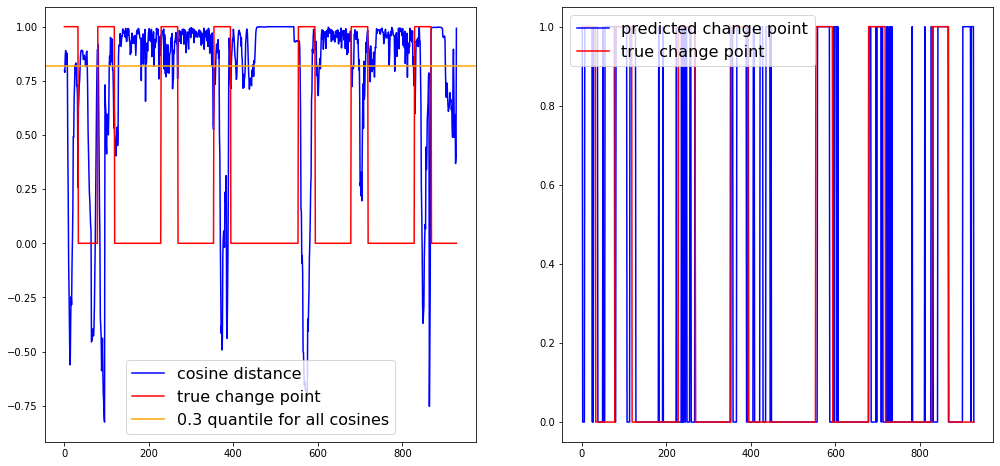

In [62]:
plt.figure(figsize = (17,8))

plt.subplot(1, 2, 1)
plt.plot(cosines, label = "cosine distance", color = "blue")
plt.plot(y_true, label = "true change point", color = "red");
plt.axhline(y = np.quantile(cosines, quantile), color = 'orange', linestyle = '-', label = f"{quantile} quantile for all cosines")
plt.legend(fontsize = 16)

plt.subplot(1,2,2)
plt.plot(y_pred, label = "predicted change point", color = "blue")
plt.plot(y_true, label = "true change point", color = "red");
plt.legend(fontsize = 16, loc = 2);


In [63]:
f1 = fuzzy_f1_score(y_true = np.array(y_true), y_pred = np.array(y_pred), margin=margin)
roc_auc = roc_auc_score(y_true = np.array(y_true), y_score = np.array(y_pred))

In [64]:
print(f"f1 (with margin) = {np.round(f1, 4)}, \nroc_auc (w/o margin) = {np.round(roc_auc, 4)}")

f1 (with margin) = 0.6232, 
roc_auc (w/o margin) = 0.7335
